# Healthcare Data Prediction - Machine Learning Classification Model

## Overview
This project develops a machine learning classification model that accurately predicts the outcome of medical tests based on patient healthcare dataset. The potential benefits include early medical interventions for diseases, medical cost and resource optimization.

In [17]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_recall_curve, average_precision_score
from sklearn.model_selection import cross_val_score
import time
import warnings
warnings.filterwarnings('ignore')

# Set random state for reproducibility
RANDOM_STATE = 42
plt.style.use('default')
sns.set_palette("husl")

## Data Loading and Initial Exploration

In [3]:
# Load the healthcare dataset
df = pd.read_csv('/content/sample_data/heart.csv')
print("Dataset loaded successfully!")
print(f"Dataset shape: {df.shape}")
print("\nDataset Info:")
print(df.info())


Dataset loaded successfully!
Dataset shape: (918, 12)

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             918 non-null    int64  
 1   Sex             918 non-null    object 
 2   ChestPainType   918 non-null    object 
 3   RestingBP       918 non-null    int64  
 4   Cholesterol     918 non-null    int64  
 5   FastingBS       918 non-null    int64  
 6   RestingECG      918 non-null    object 
 7   MaxHR           918 non-null    int64  
 8   ExerciseAngina  918 non-null    object 
 9   Oldpeak         918 non-null    float64
 10  ST_Slope        918 non-null    object 
 11  HeartDisease    918 non-null    int64  
dtypes: float64(1), int64(6), object(5)
memory usage: 86.2+ KB
None


## Data Preparation

### Trimming Data

In [5]:
# Remove duplicate rows
Cleaned_Data = df.drop_duplicates()

print(f"Original dataset shape: {df.shape}; " + f"Cleaned dataset shape: {Cleaned_Data.shape}")

Original dataset shape: (918, 12); Cleaned dataset shape: (918, 12)


### Generate Summary Statistics for Numerical Variables

Numerical columns: ['Age', 'RestingBP', 'Cholesterol', 'FastingBS', 'MaxHR', 'Oldpeak', 'HeartDisease']

Summary Statistics for Numerical Variables:
              Age   RestingBP  Cholesterol   FastingBS       MaxHR  \
count  918.000000  918.000000   918.000000  918.000000  918.000000   
mean    53.510893  132.396514   198.799564    0.233115  136.809368   
std      9.432617   18.514154   109.384145    0.423046   25.460334   
min     28.000000    0.000000     0.000000    0.000000   60.000000   
25%     47.000000  120.000000   173.250000    0.000000  120.000000   
50%     54.000000  130.000000   223.000000    0.000000  138.000000   
75%     60.000000  140.000000   267.000000    0.000000  156.000000   
max     77.000000  200.000000   603.000000    1.000000  202.000000   

          Oldpeak  HeartDisease  
count  918.000000    918.000000  
mean     0.887364      0.553377  
std      1.066570      0.497414  
min     -2.600000      0.000000  
25%      0.000000      0.000000  
50%      0.60000

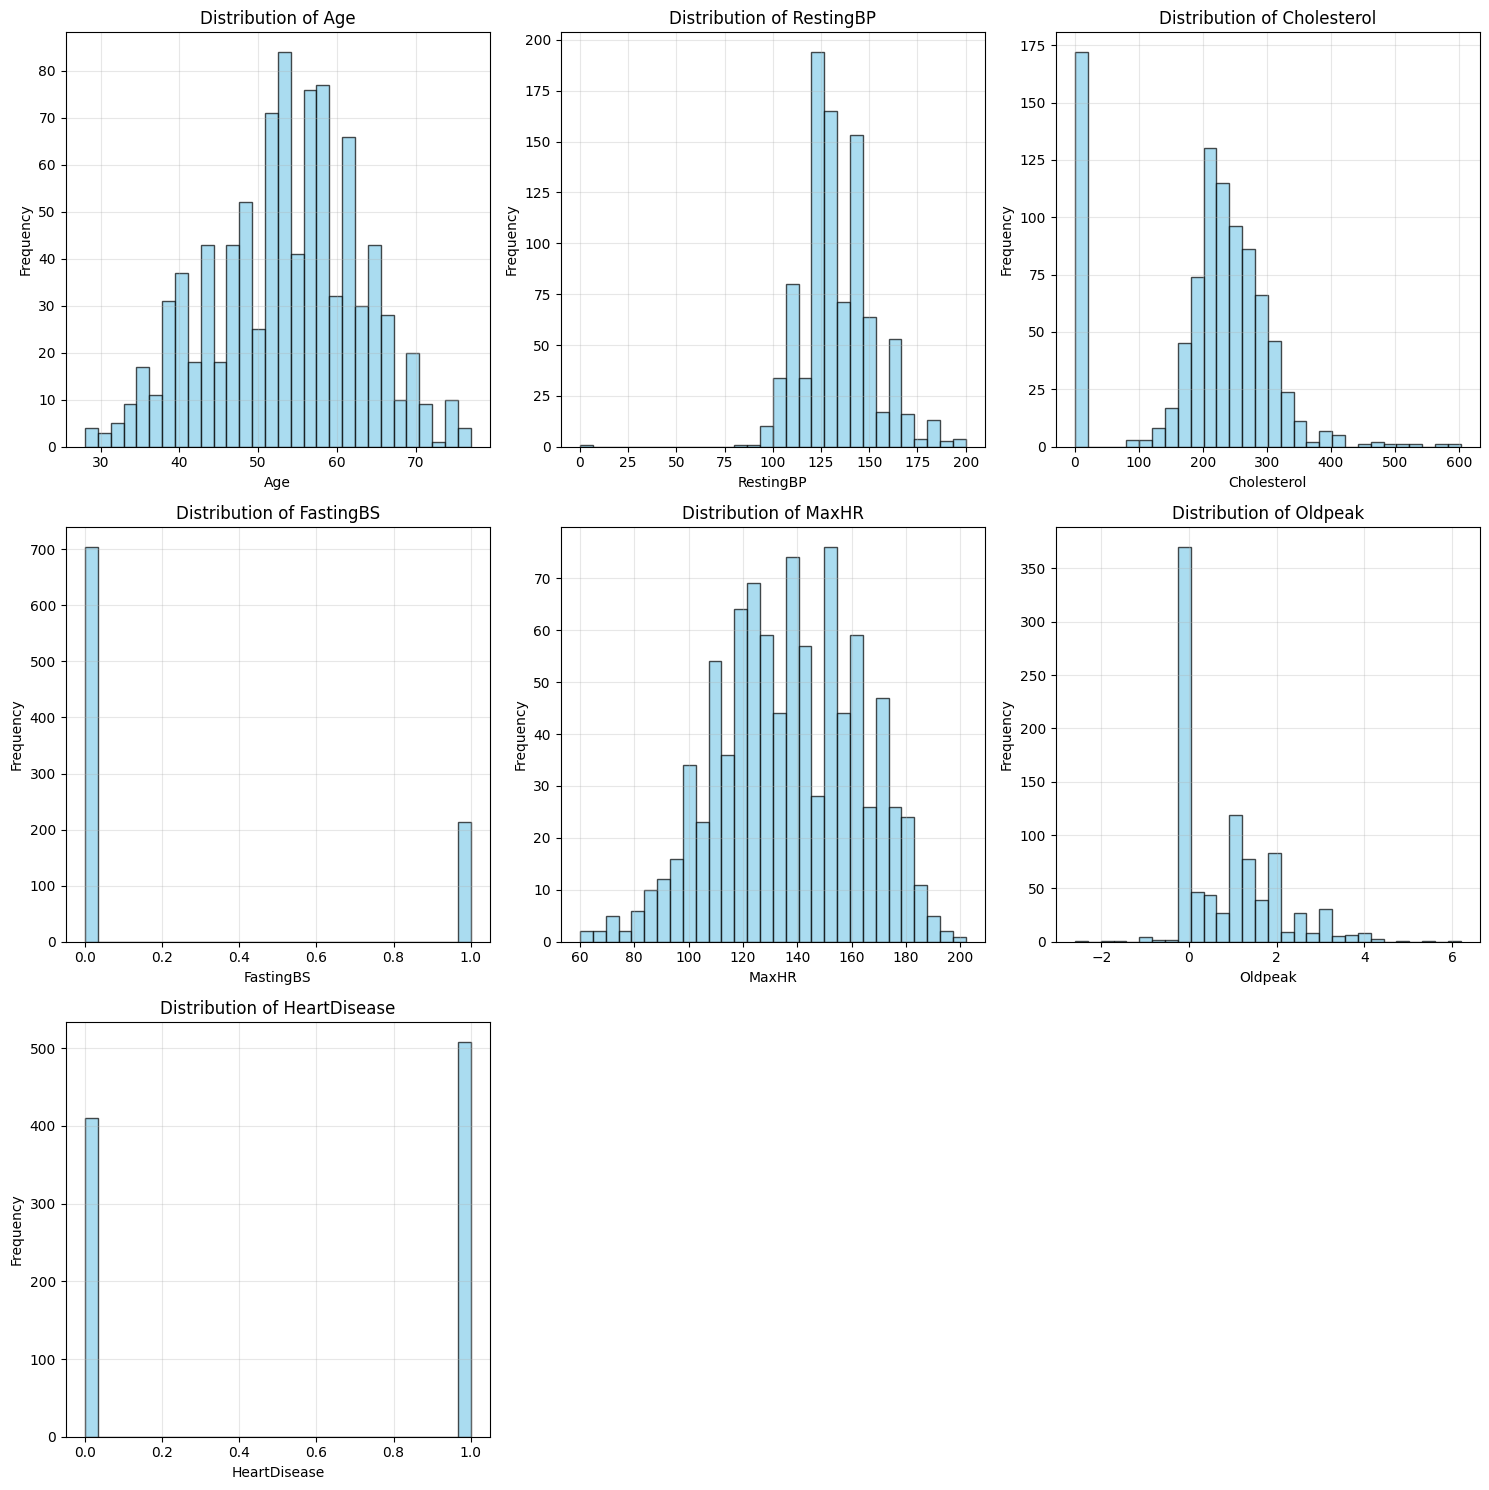

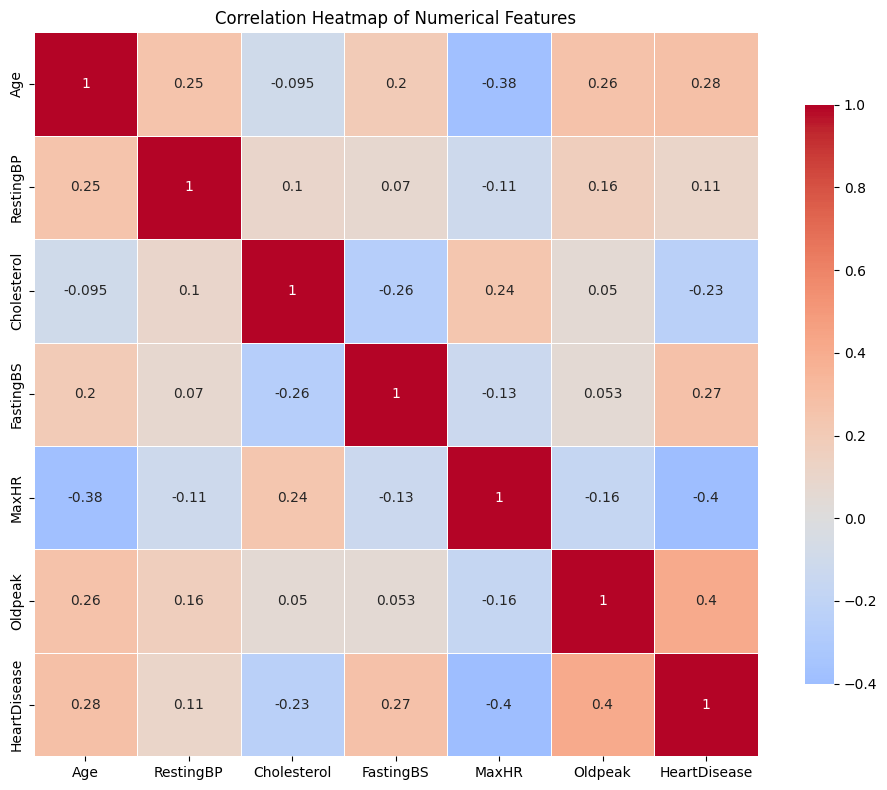


Correlation Matrix:
                   Age  RestingBP  Cholesterol  FastingBS     MaxHR   Oldpeak  \
Age           1.000000   0.254399    -0.095282   0.198039 -0.382045  0.258612   
RestingBP     0.254399   1.000000     0.100893   0.070193 -0.112135  0.164803   
Cholesterol  -0.095282   0.100893     1.000000  -0.260974  0.235792  0.050148   
FastingBS     0.198039   0.070193    -0.260974   1.000000 -0.131438  0.052698   
MaxHR        -0.382045  -0.112135     0.235792  -0.131438  1.000000 -0.160691   
Oldpeak       0.258612   0.164803     0.050148   0.052698 -0.160691  1.000000   
HeartDisease  0.282039   0.107589    -0.232741   0.267291 -0.400421  0.403951   

              HeartDisease  
Age               0.282039  
RestingBP         0.107589  
Cholesterol      -0.232741  
FastingBS         0.267291  
MaxHR            -0.400421  
Oldpeak           0.403951  
HeartDisease      1.000000  


In [6]:
# Identify numerical columns and generate summary statistics
numerical_cols = Cleaned_Data.select_dtypes(include=[np.number]).columns.tolist()
print(f"Numerical columns: {numerical_cols}")

if numerical_cols:
    print("\nSummary Statistics for Numerical Variables:")
    print(Cleaned_Data[numerical_cols].describe())

    # Create visualization for data distribution of important features
    n_cols = len(numerical_cols)
    n_rows = (n_cols + 2) // 3  # Calculate rows needed for 3 columns layout

    # Create subplots for histograms
    fig, axes = plt.subplots(n_rows, 3, figsize=(15, 5 * n_rows))
    if n_rows == 1:
        axes = axes.reshape(1, -1)
    axes = axes.flatten()

    # Plot histograms for each numerical feature
    for i, col in enumerate(numerical_cols):
        axes[i].hist(Cleaned_Data[col], bins=30, alpha=0.7, color='skyblue', edgecolor='black')
        axes[i].set_title(f'Distribution of {col}')
        axes[i].set_xlabel(col)
        axes[i].set_ylabel('Frequency')
        axes[i].grid(True, alpha=0.3)

    # Hide empty subplots
    for i in range(len(numerical_cols), len(axes)):
        axes[i].set_visible(False)

    plt.tight_layout()
    plt.show()

    # Create correlation heatmap for numerical features
    if len(numerical_cols) > 1:
        plt.figure(figsize=(10, 8))
        correlation_matrix = Cleaned_Data[numerical_cols].corr()
        sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0,
                   square=True, linewidths=0.5, cbar_kws={"shrink": .8})
        plt.title('Correlation Heatmap of Numerical Features')
        plt.tight_layout()
        plt.show()

        print("\nCorrelation Matrix:")
        print(correlation_matrix)

### Handling Missing Values

In [7]:
# Check and handle missing values
numerical_cols = Cleaned_Data.select_dtypes(include=[np.number]).columns.tolist()
categorical_cols = Cleaned_Data.select_dtypes(include=['object']).columns.tolist()

# Handle missing values in numerical features (imputation with average)
for col in numerical_cols:
    if Cleaned_Data[col].isnull().sum() > 0:
        average_value = Cleaned_Data[col].average()
        Cleaned_Data[col].fillna(average_value, inplace=True)
        print(f"Filled missing values in {col} with average: {average_value}")

# Handle missing values in categorical features (drop records)
Cleaned_Data = Cleaned_Data.dropna(subset=categorical_cols)

### Create Preprocessing Pipelines and Data Split

In [9]:
# Define target variable and features
target_column = 'HeartDisease'
X = Cleaned_Data.drop(columns=[target_column], errors='ignore')
y = Cleaned_Data[target_column] if target_column in Cleaned_Data.columns else None

# Update feature types
numerical_features = X.select_dtypes(include=[np.number]).columns.tolist()
categorical_features = X.select_dtypes(include=['object']).columns.tolist()

# Create preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(drop='first', sparse_output=False), categorical_features)
    ]
)

# Split data (80/20)
X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y
    )
print(f"\nTraining set shape: {X_train.shape}")
print(f"Test set shape: {X_test.shape}")
print(f"Training target distribution:\n{y_train.value_counts(normalize=True)}")



Training set shape: (734, 11)
Test set shape: (184, 11)
Training target distribution:
HeartDisease
1    0.553134
0    0.446866
Name: proportion, dtype: float64


## Modeling

### Baseline Model - Logistic Regression

=== Baseline Model (Logistic Regression) ===
Training time: 0.0195 seconds
Training accuracy: 0.8597
Test accuracy: 0.8859

Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.83      0.87        82
           1       0.87      0.93      0.90       102

    accuracy                           0.89       184
   macro avg       0.89      0.88      0.88       184
weighted avg       0.89      0.89      0.89       184



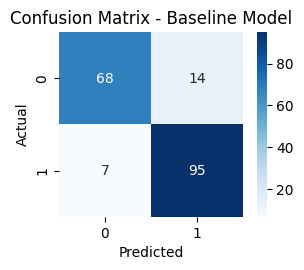

"\n# Create Model Performance Metrics Histogram\nplt.figure(figsize=(10, 6))\n\n# Accuracy and other single metrics\nsingle_metrics = []\nsingle_labels = []\nif 'accuracy' in report_dict:\n    single_metrics.append(report_dict['accuracy'])\n    single_labels.append('Accuracy')\n\n# Add training and test accuracy for comparison\nsingle_metrics.extend([train_accuracy_baseline, test_accuracy_baseline])\nsingle_labels.extend(['Train Accuracy', 'Test Accuracy'])\n\nif single_metrics:\n    colors = ['gold', 'lightblue', 'lightpink']\n    plt.bar(single_labels, single_metrics, alpha=0.8, color=colors[:len(single_metrics)])\n    plt.ylabel('Score')\n    plt.title('Model Performance Metrics - Baseline Model')\n    plt.grid(True, alpha=0.3)\n    plt.ylim(0, 1.1)\n    for i, v in enumerate(single_metrics):\n        plt.text(i, v + 0.02, f'{v:.3f}', ha='center', fontweight='bold')\n\nplt.tight_layout()\nplt.show()\n"

In [18]:
# Create and train baseline model
baseline_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(random_state=RANDOM_STATE, max_iter=1000))
])

start_time = time.time()
baseline_pipeline.fit(X_train, y_train)
training_time = time.time() - start_time

# Make predictions and calculate accuracies
y_train_pred_baseline = baseline_pipeline.predict(X_train)
y_test_pred_baseline = baseline_pipeline.predict(X_test)

train_accuracy_baseline = accuracy_score(y_train, y_train_pred_baseline)
test_accuracy_baseline = accuracy_score(y_test, y_test_pred_baseline)
report = classification_report(y_test, y_test_pred_baseline)
report_dict = classification_report(y_test, y_test_pred_baseline, output_dict=True)

print("=== Baseline Model (Logistic Regression) ===")
print(f"Training time: {training_time:.4f} seconds")
print(f"Training accuracy: {train_accuracy_baseline:.4f}")
print(f"Test accuracy: {test_accuracy_baseline:.4f}")
print(f"\nClassification Report:\n{report}")


# Plot Confusion Matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_test_pred_baseline)
plt.subplot(2, 2, 2)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', square=True)
plt.title('Confusion Matrix - Baseline Model')
plt.xlabel('Predicted')
plt.ylabel('Actual')

plt.tight_layout()
plt.show()

'''
# Create Model Performance Metrics Histogram
plt.figure(figsize=(10, 6))

# Accuracy and other single metrics
single_metrics = []
single_labels = []
if 'accuracy' in report_dict:
    single_metrics.append(report_dict['accuracy'])
    single_labels.append('Accuracy')

# Add training and test accuracy for comparison
single_metrics.extend([train_accuracy_baseline, test_accuracy_baseline])
single_labels.extend(['Train Accuracy', 'Test Accuracy'])

if single_metrics:
    colors = ['gold', 'lightblue', 'lightpink']
    plt.bar(single_labels, single_metrics, alpha=0.8, color=colors[:len(single_metrics)])
    plt.ylabel('Score')
    plt.title('Model Performance Metrics - Baseline Model')
    plt.grid(True, alpha=0.3)
    plt.ylim(0, 1.1)
    for i, v in enumerate(single_metrics):
        plt.text(i, v + 0.02, f'{v:.3f}', ha='center', fontweight='bold')

plt.tight_layout()
plt.show()
'''

### Multiple Models with Default Settings

In [19]:
# Initialize and train multiple models with default settings
models = {
    'KNN': KNeighborsClassifier(),
    'Decision Tree': DecisionTreeClassifier(random_state=RANDOM_STATE),
    'Random Forest': RandomForestClassifier(random_state=RANDOM_STATE),
    'Gradient Boosting': GradientBoostingClassifier(random_state=RANDOM_STATE),
    'SVM': SVC(random_state=RANDOM_STATE)
}

model_results = {}
model_results['Logistic Regression'] = {
    'pipeline': baseline_pipeline,
    'fit_time': training_time,
    'train_accuracy': train_accuracy_baseline,
    'test_accuracy': test_accuracy_baseline
}

for name, model in models.items():
    print(f"\n=== {name} Model ===")

    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', model)
    ])

    start_time = time.time()
    pipeline.fit(X_train, y_train)
    fit_time = time.time() - start_time

    y_train_pred = pipeline.predict(X_train)
    y_test_pred = pipeline.predict(X_test)

    train_accuracy = accuracy_score(y_train, y_train_pred)
    test_accuracy = accuracy_score(y_test, y_test_pred)

    model_results[name] = {
        'pipeline': pipeline,
        'fit_time': fit_time,
        'train_accuracy': train_accuracy,
        'test_accuracy': test_accuracy
    }

    print(f"Fit time: {fit_time:.4f} seconds")
    print(f"Training accuracy: {train_accuracy:.4f}")
    print(f"Test accuracy: {test_accuracy:.4f}")


=== KNN Model ===
Fit time: 0.0142 seconds
Training accuracy: 0.8787
Test accuracy: 0.8859

=== Decision Tree Model ===
Fit time: 0.0116 seconds
Training accuracy: 1.0000
Test accuracy: 0.7880

=== Random Forest Model ===
Fit time: 0.1903 seconds
Training accuracy: 1.0000
Test accuracy: 0.8696

=== Gradient Boosting Model ===
Fit time: 0.2094 seconds
Training accuracy: 0.9510
Test accuracy: 0.8750

=== SVM Model ===
Fit time: 0.0224 seconds
Training accuracy: 0.8883
Test accuracy: 0.8859


### Model Improvement with GridSearchCV


=== Improving Logistic Regression with GridSearchCV ===
Grid search time: 6.2612 seconds
Best parameters: {'classifier__C': 0.1, 'classifier__max_iter': 1000, 'classifier__penalty': 'l1', 'classifier__solver': 'saga'}
Best CV score: 0.8569
Test accuracy: 0.8750


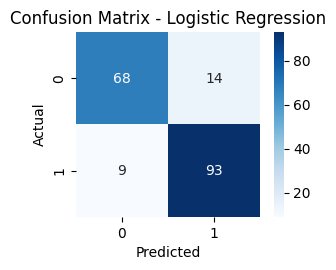


=== Improving KNN with GridSearchCV ===
Grid search time: 0.5249 seconds
Best parameters: {'classifier__metric': 'euclidean', 'classifier__n_neighbors': 9, 'classifier__weights': 'uniform'}
Best CV score: 0.8637
Test accuracy: 0.8750


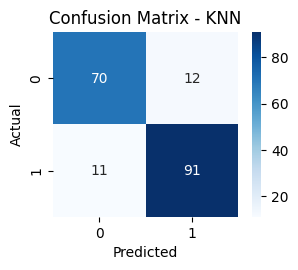


=== Improving Decision Tree with GridSearchCV ===
Grid search time: 6.7793 seconds
Best parameters: {'classifier__criterion': 'entropy', 'classifier__max_depth': 5, 'classifier__min_samples_leaf': 4, 'classifier__min_samples_split': 2}
Best CV score: 0.8351
Test accuracy: 0.8098


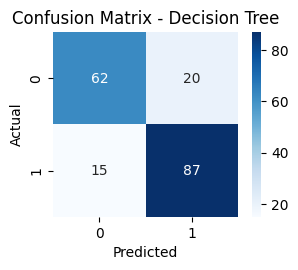


=== Improving Random Forest with GridSearchCV ===
Grid search time: 54.0901 seconds
Best parameters: {'classifier__max_depth': 10, 'classifier__min_samples_split': 5, 'classifier__n_estimators': 200}
Best CV score: 0.8664
Test accuracy: 0.8804


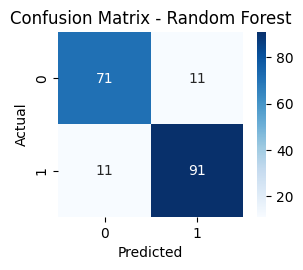


=== Improving Gradient Boosting with GridSearchCV ===
Grid search time: 18.7140 seconds
Best parameters: {'classifier__learning_rate': 0.01, 'classifier__n_estimators': 200}
Best CV score: 0.8596
Test accuracy: 0.8641


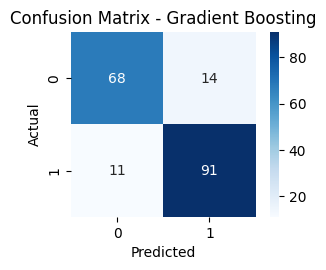


=== Improving SVM with GridSearchCV ===
Grid search time: 0.3967 seconds
Best parameters: {'classifier__C': 1, 'classifier__kernel': 'linear'}
Best CV score: 0.8542
Test accuracy: 0.8804


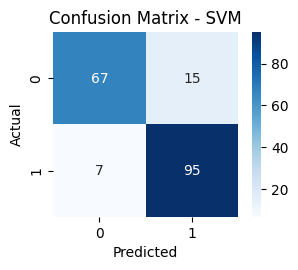

In [20]:
# Define hyperparameter grids
param_grids = {
    'Logistic Regression': {
        'classifier__C': [0.1, 1, 10],
        'classifier__penalty': ['l1', 'l2'],
        'classifier__solver': ['liblinear', 'saga'],
        'classifier__max_iter': [1000, 2000]
    },
    'KNN': {
        'classifier__n_neighbors': [5, 9],
        'classifier__weights': ['uniform', 'distance'],
        'classifier__metric': ['euclidean']
    },
    'Decision Tree': {
        'classifier__max_depth': [5, 10, 15, None],
        'classifier__min_samples_split': [2, 5, 10],
        'classifier__min_samples_leaf': [1, 2, 4],
        'classifier__criterion': ['gini', 'entropy']
    },
    'Random Forest': {
        'classifier__n_estimators': [100, 200, 400],
        'classifier__max_depth': [10, 15, None],
        'classifier__min_samples_split': [2, 5, 10]
    },
    'Gradient Boosting': {
        'classifier__n_estimators': [100, 200, 500],
        'classifier__learning_rate': [0.01, 0.1, 0.2]
    },
    'SVM': {
        'classifier__C': [1, 10],
        'classifier__kernel': ['linear']
    }
}

improved_models = {
    'Logistic Regression': LogisticRegression(random_state=RANDOM_STATE),
    'KNN': KNeighborsClassifier(),
    'Decision Tree': DecisionTreeClassifier(random_state=RANDOM_STATE),
    'Random Forest': RandomForestClassifier(random_state=RANDOM_STATE),
    'Gradient Boosting': GradientBoostingClassifier(random_state=RANDOM_STATE),
    'SVM': SVC(random_state=RANDOM_STATE)
}

improved_results = {}

# Perform GridSearchCV for each model
for name, model in improved_models.items():
    print(f"\n=== Improving {name} with GridSearchCV ===")

    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', model)
    ])

    start_time = time.time()
    grid_search = GridSearchCV(
        pipeline, param_grids[name], cv=5, scoring='accuracy', n_jobs=-1
    )
    grid_search.fit(X_train, y_train)
    grid_time = time.time() - start_time

    best_pipeline = grid_search.best_estimator_
    y_train_pred = best_pipeline.predict(X_train)
    y_test_pred = best_pipeline.predict(X_test)

    train_accuracy = accuracy_score(y_train, y_train_pred)
    test_accuracy = accuracy_score(y_test, y_test_pred)

    improved_results[name] = {
        'best_pipeline': best_pipeline,
        'best_params': grid_search.best_params_,
        'cv_score': grid_search.best_score_,
        'grid_time': grid_time,
        'train_accuracy': train_accuracy,
        'test_accuracy': test_accuracy
    }

    print(f"Grid search time: {grid_time:.4f} seconds")
    print(f"Best parameters: {grid_search.best_params_}")
    print(f"Best CV score: {grid_search.best_score_:.4f}")
    print(f"Test accuracy: {test_accuracy:.4f}")

    cm = confusion_matrix(y_test, y_test_pred)
    plt.subplot(2, 2, 2)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', square=True)
    plt.title(f'Confusion Matrix - {name}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')

    plt.tight_layout()
    plt.show()


=== Cross-Validation for Improved Models ===

Performing cross-validation for Logistic Regression...
CV Scores: [0.89795918 0.86394558 0.85714286 0.84353741 0.82191781]
CV Mean: 0.8569
CV Std: 0.0251

Performing cross-validation for KNN...
CV Scores: [0.8707483  0.87755102 0.87755102 0.84353741 0.84931507]
CV Mean: 0.8637
CV Std: 0.0145

Performing cross-validation for Decision Tree...
CV Scores: [0.8707483  0.82993197 0.86394558 0.81632653 0.79452055]
CV Mean: 0.8351
CV Std: 0.0287

Performing cross-validation for Random Forest...
CV Scores: [0.91156463 0.8707483  0.87755102 0.84353741 0.82876712]
CV Mean: 0.8664
CV Std: 0.0287

Performing cross-validation for Gradient Boosting...
CV Scores: [0.89795918 0.86394558 0.89115646 0.83673469 0.80821918]
CV Mean: 0.8596
CV Std: 0.0336

Performing cross-validation for SVM...
CV Scores: [0.89795918 0.88435374 0.84353741 0.84353741 0.80136986]
CV Mean: 0.8542
CV Std: 0.0342


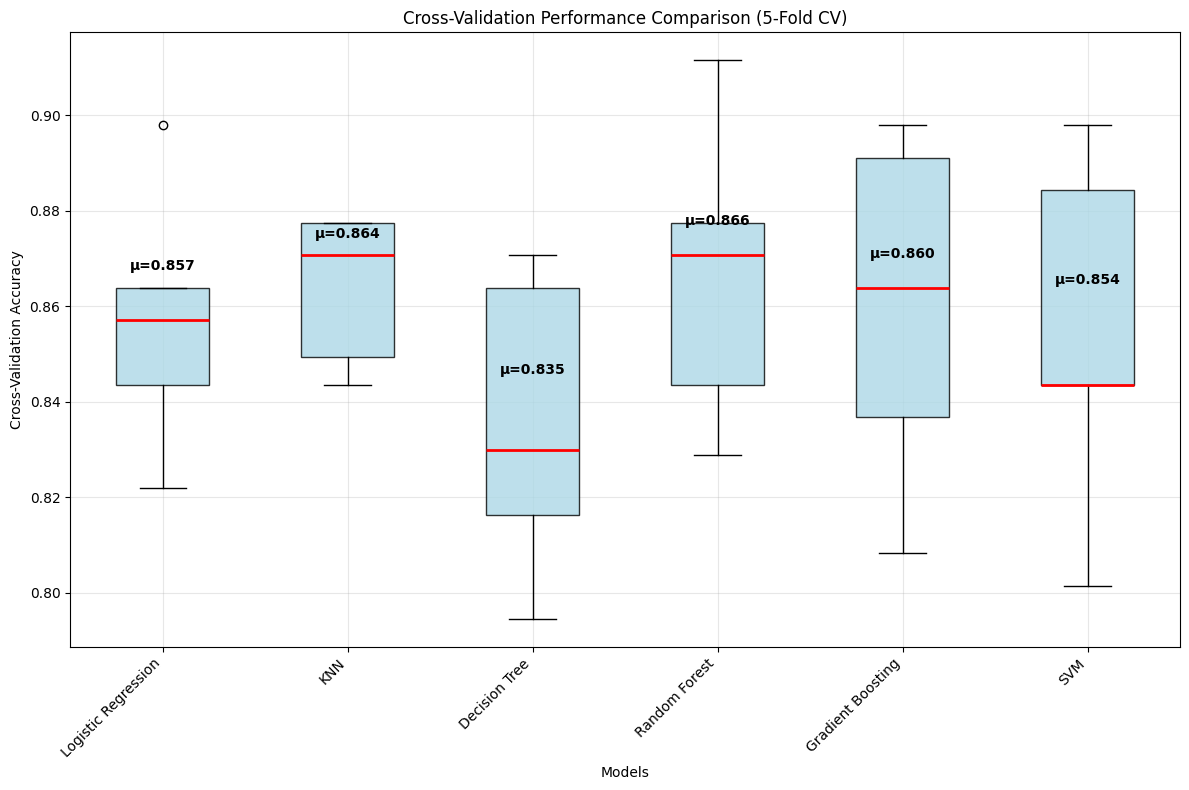


Cross-Validation Summary:
                 Model  CV_Mean  CV_Std  Test_Accuracy
0  Logistic Regression   0.8569  0.0251         0.8750
1                  KNN   0.8637  0.0145         0.8750
2        Decision Tree   0.8351  0.0287         0.8098
3        Random Forest   0.8664  0.0287         0.8804
4    Gradient Boosting   0.8596  0.0336         0.8641
5                  SVM   0.8542  0.0342         0.8804


In [21]:
# Cross-validation for improved models
print("\n=== Cross-Validation for Improved Models ===")
cv_results = {}

for name, results in improved_results.items():
    print(f"\nPerforming cross-validation for {name}...")

    # Get the best pipeline from improved results
    best_pipeline = results['best_pipeline']

    # Perform 5-fold cross-validation
    cv_scores = cross_val_score(best_pipeline, X_train, y_train, cv=5, scoring='accuracy')

    # Store results
    cv_results[name] = {
        'cv_scores': cv_scores,
        'cv_mean': cv_scores.mean(),
        'cv_std': cv_scores.std()
    }

    print(f"CV Scores: {cv_scores}")
    print(f"CV Mean: {cv_scores.mean():.4f}")
    print(f"CV Std: {cv_scores.std():.4f}")

## Create visualization for cross-validation results
plt.figure(figsize=(12, 8))

## Box plot for CV scores
cv_data = [cv_results[name]['cv_scores'] for name in cv_results.keys()]
cv_labels = list(cv_results.keys())

plt.boxplot(cv_data, labels=cv_labels, patch_artist=True,
           boxprops=dict(facecolor='lightblue', alpha=0.8),
           medianprops=dict(color='red', linewidth=2))

plt.xlabel('Models')
plt.ylabel('Cross-Validation Accuracy')
plt.title('Cross-Validation Performance Comparison (5-Fold CV)')
plt.xticks(rotation=45, ha='right')
plt.grid(True, alpha=0.3)

## Add mean values as text annotations
for i, (name, results) in enumerate(cv_results.items()):
    plt.text(i+1, results['cv_mean'] + 0.01, f'μ={results["cv_mean"]:.3f}',
             ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

## Summary table for cross-validation results
cv_summary_data = []
for name, results in cv_results.items():
    cv_summary_data.append({
        'Model': name,
        'CV_Mean': results['cv_mean'],
        'CV_Std': results['cv_std'],
        'Test_Accuracy': improved_results[name]['test_accuracy']
    })

cv_summary_df = pd.DataFrame(cv_summary_data)
print("\nCross-Validation Summary:")
print(cv_summary_df.round(4))

### Model Comparison and Visualization

Model Comparison:
                             Model      Type  Train_Accuracy  Test_Accuracy  \
0              Logistic Regression   Default        0.859673       0.885870   
1                              KNN   Default        0.878747       0.885870   
2                    Decision Tree   Default        1.000000       0.788043   
3                    Random Forest   Default        1.000000       0.869565   
4                Gradient Boosting   Default        0.950954       0.875000   
5                              SVM   Default        0.888283       0.885870   
6   Logistic Regression (Improved)  Improved        0.863760       0.875000   
7                   KNN (Improved)  Improved        0.880109       0.875000   
8         Decision Tree (Improved)  Improved        0.876022       0.809783   
9         Random Forest (Improved)  Improved        0.959128       0.880435   
10    Gradient Boosting (Improved)  Improved        0.886921       0.864130   
11                  SVM (Improved)

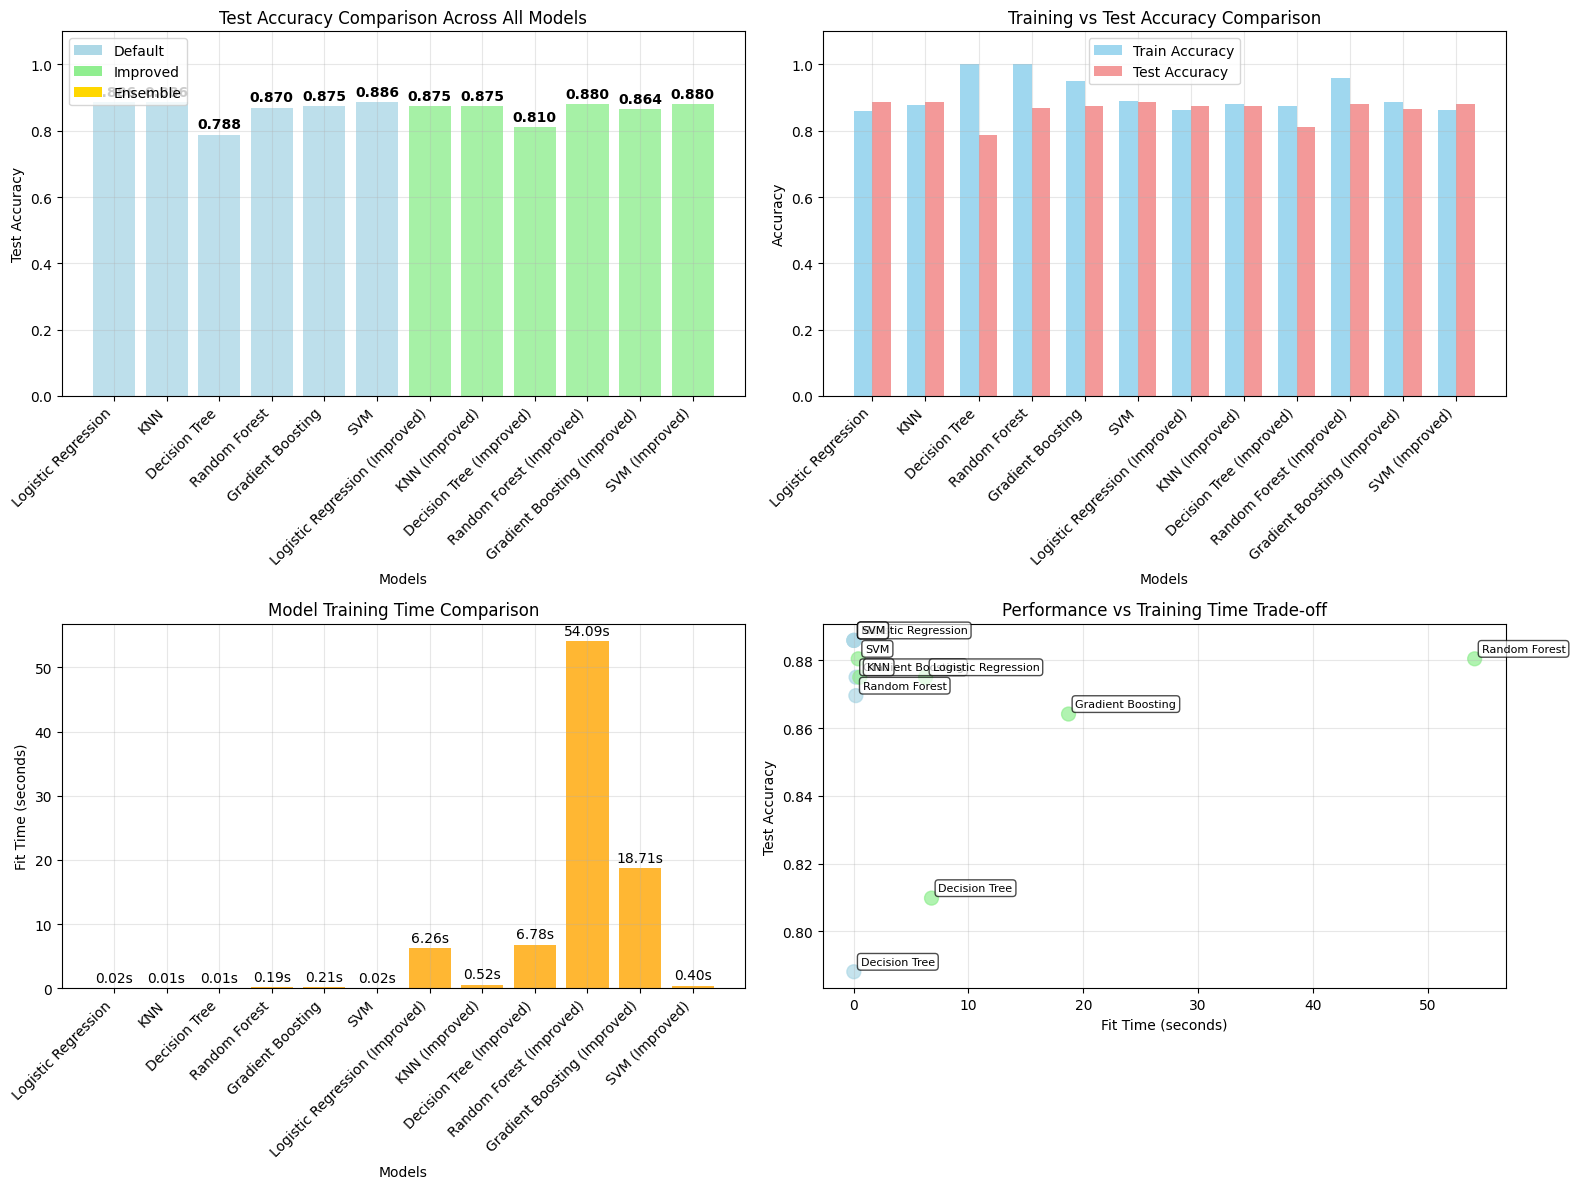

In [24]:
# Create comparison dataframe
comparison_data = []

for name, results in model_results.items():
    comparison_data.append({
        'Model': name,
        'Type': 'Default',
        'Train_Accuracy': results['train_accuracy'],
        'Test_Accuracy': results['test_accuracy'],
        'Fit_Time': results['fit_time']
    })

for name, results in improved_results.items():
    comparison_data.append({
        'Model': f"{name} (Improved)",
        'Type': 'Improved',
        'Train_Accuracy': results['train_accuracy'],
        'Test_Accuracy': results['test_accuracy'],
        'Fit_Time': results['grid_time']
    })

comparison_df = pd.DataFrame(comparison_data)
print("Model Comparison:")
print(comparison_df)

# Find best model
best_model_idx = comparison_df['Test_Accuracy'].idxmax()
best_model = comparison_df.loc[best_model_idx, 'Model']
best_accuracy = comparison_df.loc[best_model_idx, 'Test_Accuracy']

print(f"\n=== BEST MODEL ===")
print(f"Model: {best_model}")
print(f"Test Accuracy: {best_accuracy:.4f}")

# Create comprehensive model performance visualization
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Test Accuracy Comparison
ax1 = axes[0, 0]
models = comparison_df['Model']
test_accuracies = comparison_df['Test_Accuracy']
colors = ['lightblue' if 'Default' in str(comparison_df.loc[i, 'Type']) else
          'lightgreen' if 'Improved' in str(comparison_df.loc[i, 'Type']) else
          'gold' for i in range(len(comparison_df))]

bars1 = ax1.bar(range(len(models)), test_accuracies, color=colors, alpha=0.8)
ax1.set_xlabel('Models')
ax1.set_ylabel('Test Accuracy')
ax1.set_title('Test Accuracy Comparison Across All Models')
ax1.set_xticks(range(len(models)))
ax1.set_xticklabels(models, rotation=45, ha='right')
ax1.grid(True, alpha=0.3)
ax1.set_ylim(0, 1.1)

# Add value annotations
for i, v in enumerate(test_accuracies):
    ax1.text(i, v + 0.01, f'{v:.3f}', ha='center', va='bottom', fontweight='bold')

# Add legend
from matplotlib.patches import Patch
legend_elements = [Patch(facecolor='lightblue', label='Default'),
                   Patch(facecolor='lightgreen', label='Improved'),
                   Patch(facecolor='gold', label='Ensemble')]
ax1.legend(handles=legend_elements, loc='upper left')

# 2. Training vs Test Accuracy Comparison
ax2 = axes[0, 1]
train_accuracies = comparison_df['Train_Accuracy']
x = np.arange(len(models))
width = 0.35

bars2 = ax2.bar(x - width/2, train_accuracies, width, label='Train Accuracy', alpha=0.8, color='skyblue')
bars3 = ax2.bar(x + width/2, test_accuracies, width, label='Test Accuracy', alpha=0.8, color='lightcoral')

ax2.set_xlabel('Models')
ax2.set_ylabel('Accuracy')
ax2.set_title('Training vs Test Accuracy Comparison')
ax2.set_xticks(x)
ax2.set_xticklabels(models, rotation=45, ha='right')
ax2.legend()
ax2.grid(True, alpha=0.3)
ax2.set_ylim(0, 1.1)

# 3. Fit Time Comparison
ax3 = axes[1, 0]
fit_times = comparison_df['Fit_Time']
bars4 = ax3.bar(range(len(models)), fit_times, color='orange', alpha=0.8)
ax3.set_xlabel('Models')
ax3.set_ylabel('Fit Time (seconds)')
ax3.set_title('Model Training Time Comparison')
ax3.set_xticks(range(len(models)))
ax3.set_xticklabels(models, rotation=45, ha='right')
ax3.grid(True, alpha=0.3)

# Add value annotations for fit times
for i, v in enumerate(fit_times):
    ax3.text(i, v + max(fit_times) * 0.01, f'{v:.2f}s', ha='center', va='bottom')

# 4. Performance Summary (Test Accuracy vs Fit Time)
ax4 = axes[1, 1]
scatter_colors = colors
scatter = ax4.scatter(fit_times, test_accuracies, c=scatter_colors, s=100, alpha=0.7)
ax4.set_xlabel('Fit Time (seconds)')
ax4.set_ylabel('Test Accuracy')
ax4.set_title('Performance vs Training Time Trade-off')
ax4.grid(True, alpha=0.3)

# Add model labels to scatter plot
for i, model in enumerate(models):
    ax4.annotate(model.split('(')[0].strip(), (fit_times[i], test_accuracies[i]),
                xytext=(5, 5), textcoords='offset points', fontsize=8,
                bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.7))

plt.tight_layout()
plt.show()



# Next and Recommendation

Although the test accuracy of KNN model can reached over 88% accuracy, but it is still have space to be improved to a higher accuracy. Given Deep Neural Network (DNN) currently has a significant improved due to the reduction of computation if we are using GPU to process the learning process, we can consider to build up a model via multiple layers neural network technology. During the processing, it should be able to generate more intermediate features and eventually enhance the model accuracy.